# Segmentación semántica de imágenes satélitales de La Laguna de La Cocha con K-means

Este script se encuentra inspirado en el trabajo realizado por Rozanov (2024) [Semantic Segmentation of Remote Sensing Imagery using k-Means](https://towardsdatascience.com/semantic-segmentation-of-remote-sensing-imagery-using-k-means-e4c165d9218e) a  la vez ha sido complementado utilizando el copiloto de Google Colab y ChatGPT, de acuerdo con las necesidades del análisis en el caso de aplicación para las imagenes satelitales Landsat 7 del año 2002 y Planet del año 2024, del área circundante de la Laguna de La Cocha

* El objetivo es lograr identificar cambios de cobertura de la tierra entre los años y evidenciar el potencial de los modelos de aprendizaje no supervisado para el análisis de elementos territoriales en la Región Hídrica del Valle de Atríz

* Teniendo en cuenta que la procedencia de las imágenes es de dos fuentes diferentes, y esto conlleva a procesamientos previos no equivalente, se decide aplicar el modelo a cada imagen por separado

# Área de interés




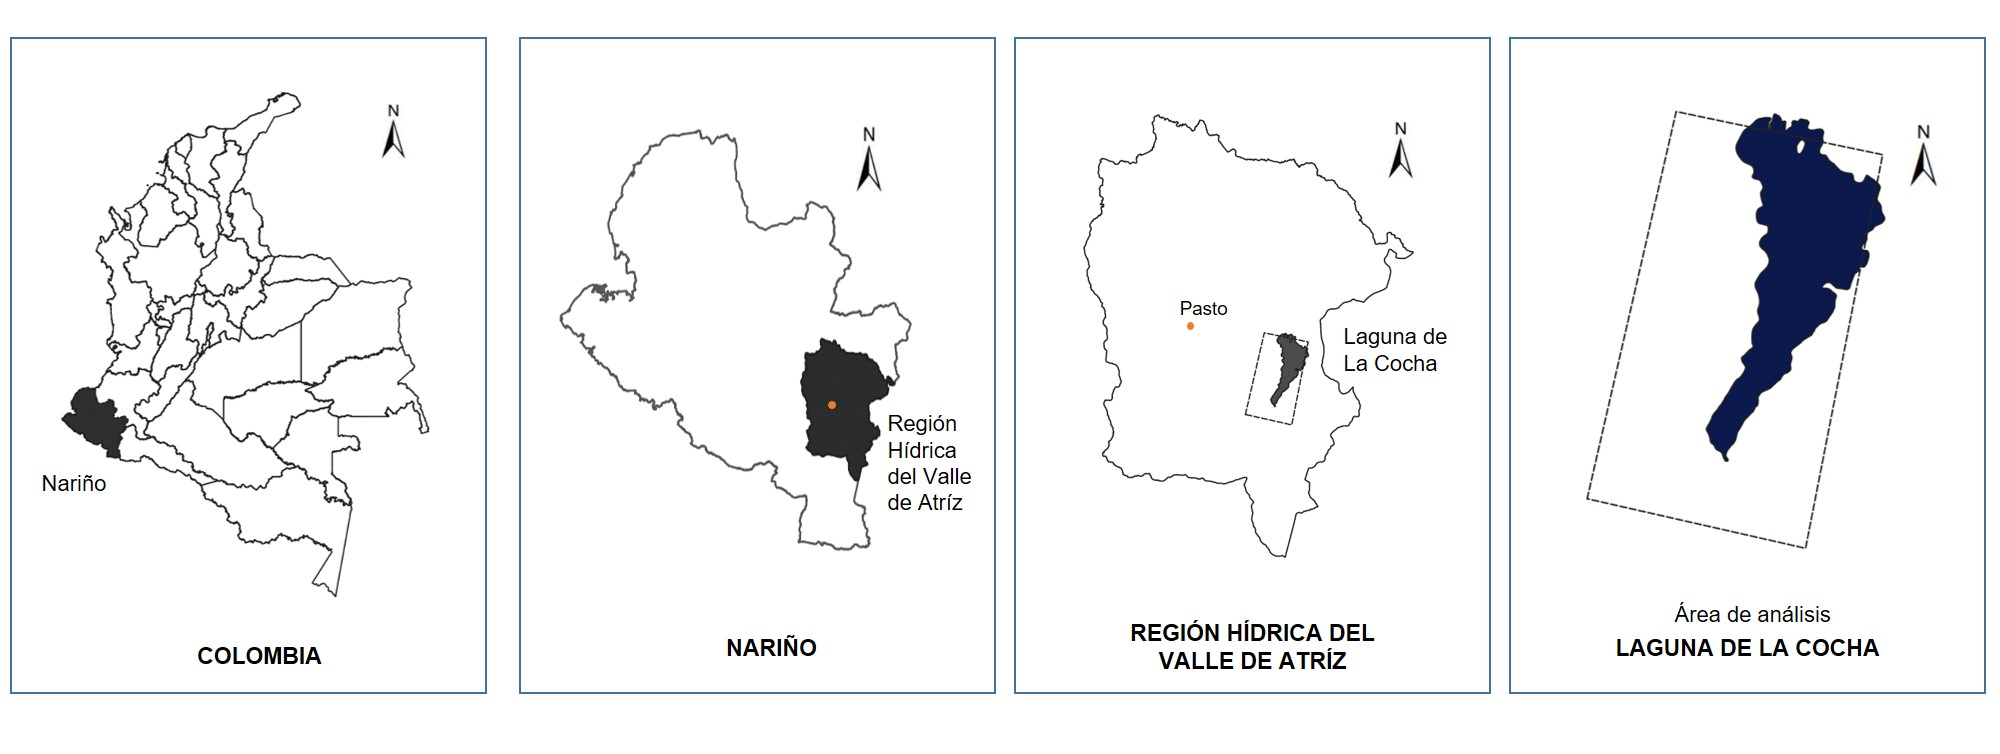

Geometría del área de análisis

| Coordenadas |
|--------------|
| -77.2049604, 1.1875262 |
| -77.2152636, 0.9943284 |
| -77.0864735, 0.999819 |
| -77.0868169, 1.1906145 |
|-77.2049604, 1.1875262,  |
| Tipo: Polígono |


# Configuración del entorno

Aquí se instalan librerías necesarias y se importan módulos para aplicar el modelo, hacer cálculos y visualizaciones

In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 31.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import io
from matplotlib.colors import ListedColormap
from rasterio import open
import json
import rasterio
from rasterio.windows import from_bounds
from google.colab import files
import pandas as pd

import matplotlib.image as mpimg
# Si usas imágenes en formato PNG o JPG, puedes usar PIL
from PIL import Image



In [ ]:
from PIL import Image

Image.MAX_IMAGE_PIXELS = None  # Desactiva el límite de tamaño de imagen

# Carga de imagenes y preprocesamiento

En este paso se realiza la importación de las dos imágenes satélitales con las siguientes características

| Características | Imagen 2002 | Imagen 2024|
|--------------|--------------|--------------|
| Proveedor    | Landsat 7     | Planet    |
| Resolución  |30m  | Celda 6      | 3m
| Obtención | Code Editor de Google Earth Engine | Adquisición por empresa Ecosimple SAS     |
| Procesamiento | Extracción de bandas RGB en QGIS    | Reproyección a 3 m y extracción de bandas RGB en QGIS      |
| Formato |JPG    | GeoTIFF      |


## Imagen 2002

In [ ]:
# Abre la imagen JPG
image1 = Image.open('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Data/2002/Landsat7_2002_LaCocha.jpg')

In [ ]:

# Convierte la imagen a un array NumPy
image1_array = np.array(image1)

# Crea una máscara para los bordes y píxeles negros
mascara = np.ones(image1_array.shape[:2], dtype=bool)
""""
mascara[0,:] = False  # Borde superior
mascara[-1,:] = False # Borde inferior
mascara[:,0] = False  # Borde izquierdo
mascara[:,-1] = False # Borde derecho
"""
mascara[image1_array[:,:,0] == 0] = False  # Píxeles negros (asumiendo que el negro es 0 en todos los canales)

# Aplica la máscara a la imagen
imagen_array_enmascarada = image1_array[mascara]

## Imagen 2024

In [ ]:
# Abrir la imagen 2024 GeoTiFF

image_path2 = '/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Data/2024/LaCocha_2024.tif'  # Reemplaza con la ruta de tu imagen 1

with rasterio.open(image_path2) as src:
    image2 = src.read()
    profile1 = src.profile

# Transponer las imágenes para que los canales sean el último eje
image2 = np.transpose(image2, (1, 2, 0))

print("Shape de imagen original", image2.shape)

# Eliminar valores NaN y negros
mask2 = ~np.isnan(image2).any(axis=2) & ~np.all(image2 == 0, axis=2)


image2_masked = image2[mask2]

print("Shape de imagen con máscara", image2_masked.shape)

# Aplanar las imágenes para KMeans
image2_flat = image2_masked.reshape(-1, image2_masked.shape[-1])

print(image2_flat.shape)







Shape de imagen original (601, 410, 4)
Shape de imagen con máscara (166212, 4)
(166212, 4)


# Visualización

A continuación, se visualizan las imágenes satélitales a comparar de los años 2002 y 2024. Además, se visualiza el enmascaramiento de los bordes negros, asegurando que la segmentación se realice unicamente con el área de interés

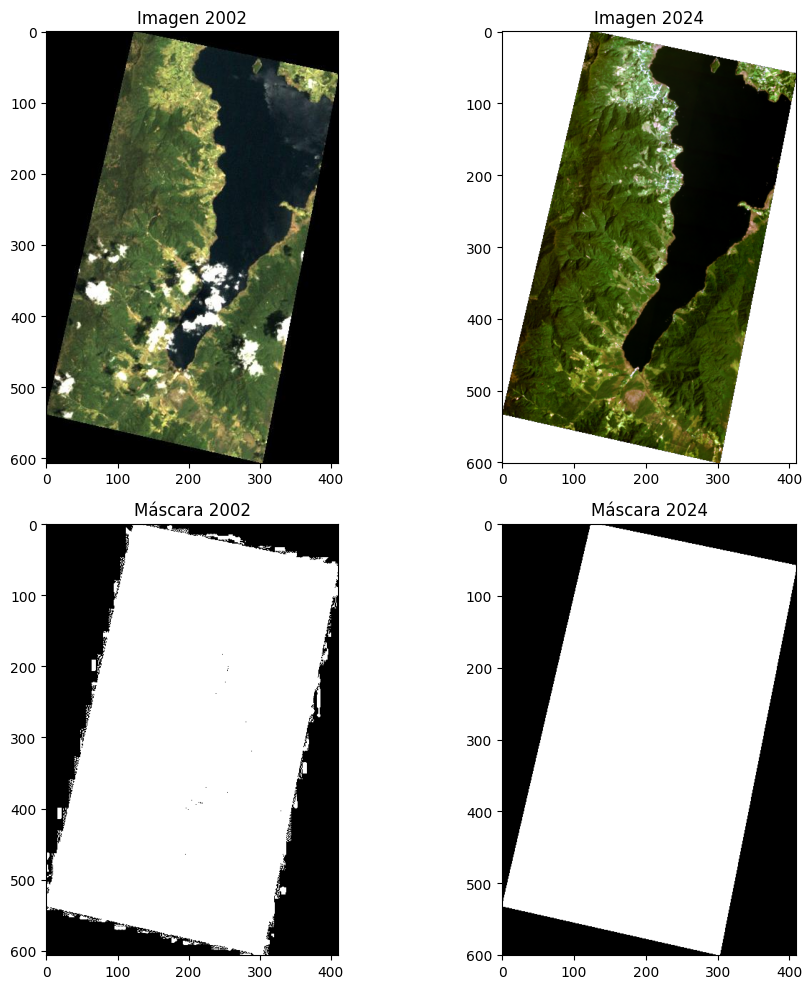

In [ ]:
#
# Crea una figura con 2 filas y 2 columnas
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Muestra la imagen 1 en la primera subgráfica
axs[0, 0].imshow(image1)
axs[0, 0].set_title('Imagen 2002')

# Muestra la máscara 1 en la segunda subgráfica
axs[0, 1].imshow(image2)
axs[0, 1].set_title('Imagen 2024')

# Muestra la imagen 2 en la tercera subgráfica
axs[1, 0].imshow(mascara, cmap='gray')
axs[1, 0].set_title('Máscara 2002')

# Muestra la máscara 2 en la cuarta subgráfica

axs[1, 1].imshow(mask2, cmap='gray')
axs[1, 1].set_title('Máscara 2024')

# Ajusta el espacio entre las subgráficas
plt.tight_layout()

# Muestra la figura
plt.show()


# Aplicación de segmentación con K-means

Se utiliza la biblioteca sklearn para cálculo de la inercia, la aplicación del modelo y el cálculo del coeficiente de silueta como medida del desempeño

La inercia se calcula para estimar el número de clúster: k


## Cálculo de inercia para cada imágen

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Inercia para la imagen 1: [1542381112.164142, 573526128.6005017, 307390836.986455, 143422710.44677615, 99756134.33666225, 73892605.43165994, 61818358.60645638, 53901868.90818332, 46876989.586061805, 41486627.93130425]
Inercia para la imagen 2: [979596207.6866971, 400954554.69481313, 198020220.19340435, 117651741.02259135, 85368726.10311276, 63478207.35293203, 52302571.31993409, 44518235.15157404, 38976702.37689568, 35017451.75932791]


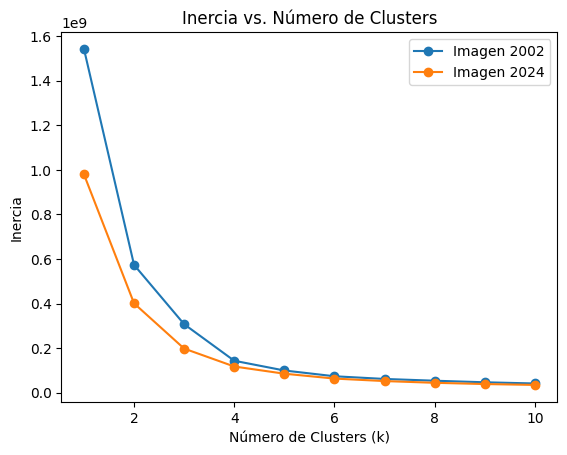

In [ ]:

# Inercia imagen 1

inertia_img1 = []
k_values = range(1, 11)  # Prueba con valores de k de 1 a 10
for k in k_values:
  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(imagen_array_enmascarada.reshape(-1, 3))  # Ajusta el modelo a los datos
  inertia_img1.append(kmeans.inertia_)

# Inercia imagen 2

inertia_img2 = []

# Reshape de las imágenes a 2D
img2_reshaped = image2_masked.reshape(-1, image2_masked.shape[-1])

# Calcular k-means para valores de k de 1 a 10 para ambas imágenes
for k in range(1, 11):
    kmeans_img2 = KMeans(n_clusters=k, random_state=0).fit(img2_reshaped)
    inertia_img2.append(kmeans_img2.inertia_)

# Imprime los resultados
print("Inercia para la imagen 1:", inertia_img1)
print("Inercia para la imagen 2:", inertia_img2)

# Grafica la inercia para ambas imágenes
plt.plot(k_values, inertia_img1, marker='o', label='Imagen 2002')
plt.plot(k_values, inertia_img2, marker='o', label='Imagen 2024')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Inercia vs. Número de Clusters')
plt.legend()

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/inercia_plot.png')
plt.show()




## Aplicación de K-means a cada imagen con K=4

In [ ]:
k1=4
k2=4

# Kmeans imagen 2002

kmeans1 = KMeans(n_clusters=k1, random_state=42).fit(imagen_array_enmascarada.reshape(-1, 3))
# Obtiene las etiquetas de los clusters
labels1 = kmeans1.labels_

segmented_image1 = np.zeros(image1_array.shape[:2], dtype=int)
segmented_image1[mascara] = labels1 + 1

# Kmean Imagen 2024

# Aplica KMeans a la imagen enmascarada
kmeans2 = KMeans(n_clusters=k2, random_state=42).fit(image2_flat)
# Obtén las etiquetas de los clusters
labels2 = kmeans2.labels_
# Reasigna las etiquetas a la forma original de la imagen enmascarada
labels2_reshaped = labels2.reshape(166212)
# Crea una imagen segmentada
segmented_image2 = np.zeros((image2.shape[0], image2.shape[1]), dtype=np.uint8)
segmented_image2[mask2] = labels2_reshaped + 1  # +1 para evitar el valor 0 que se usa para el fondo



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
# numero de iteraciones realizadas

print("Número de iteraciones para la imagen 2002:", kmeans1.n_iter_)
print("Número de iteraciones para la imagen 2024:", kmeans2.n_iter_)


Número de iteraciones para la imagen 2002: 6
Número de iteraciones para la imagen 2024: 10


In [ ]:
# convertir a dataframe el numero de iteraciones y descargar en csv

# Crea un diccionario con los datos
iteraciones = {'Imagen': ['2002', '2024'],
        'Iteraciones': [kmeans1.n_iter_, kmeans2.n_iter_]}

# Crea un DataFrame a partir del diccionario
df = pd.DataFrame(iteraciones)

# Guarda el DataFrame en un archivo CSV
df.to_csv('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/iteraciones.csv', index=False)




## Resultados de segmentación para cada imagen

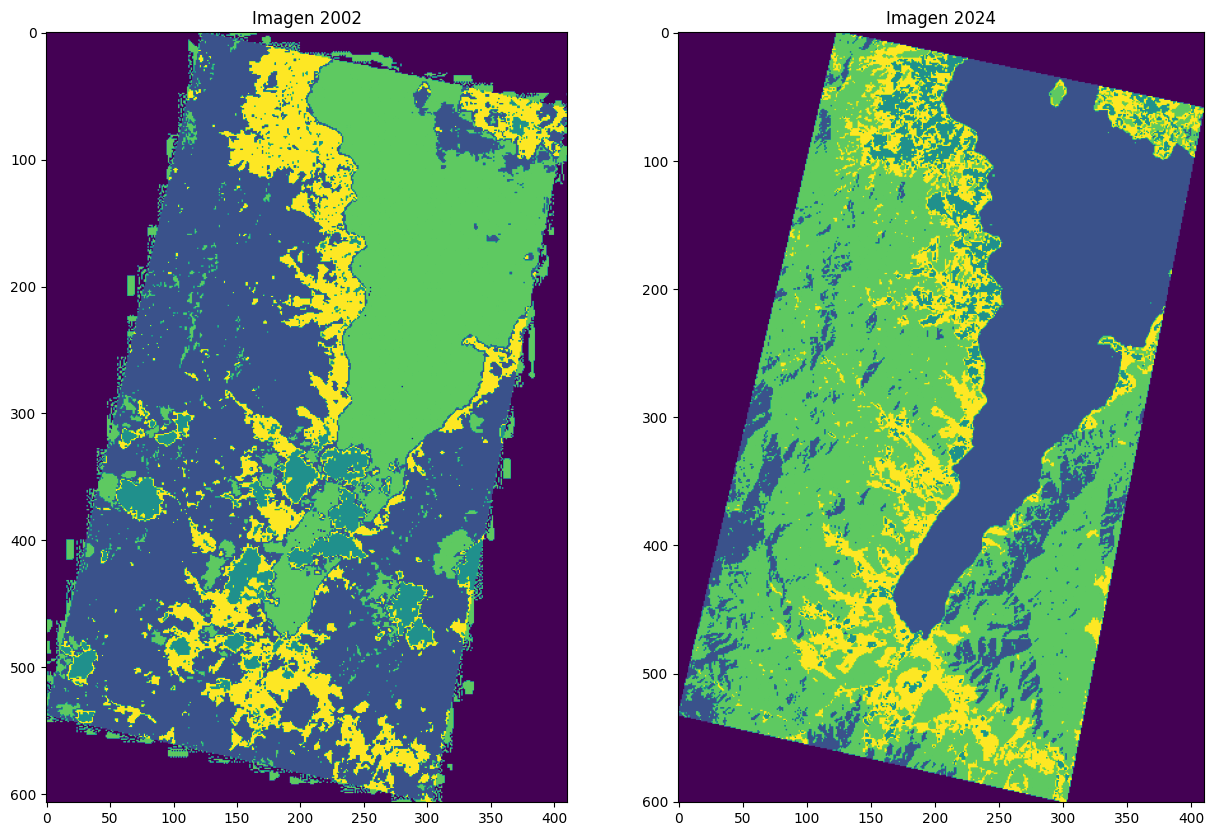

In [ ]:
# Visualizar la imagen original y la máscara
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Mostrar la imagen original
axs[0].imshow(segmented_image1, cmap='viridis')
axs[0].set_title('Imagen 2002')

# Mostrar la máscara
axs[1].imshow(segmented_image2, cmap='viridis')
axs[1].set_title('Imagen 2024')

# Guarda la figura en un archivo
plt.savefig('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/imagenes_segmentadas.png')

plt.show()

## Coeficiente de silueta para evaluar desempeño

El coeficiente de silueta se calcula utilizando la distancia media entre clústeres ( a) y la distancia media entre clústeres más cercanos ( b) para cada muestra.

El mejor valor es 1 y el peor valor es -1. Los valores cercanos a 0 indican conglomerados superpuestos. Los valores negativos generalmente indican que una muestra ha sido asignada al conglomerado equivocado, ya que un conglomerado diferente es más similar.

Fuente: [Coeficiente de silueta sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [ ]:
from sklearn.metrics import silhouette_score

# Calcula el coeficiente de silueta para la imagen 2002
silhouette_avg1 = silhouette_score(imagen_array_enmascarada.reshape(-1, 3), labels1)
print("Coeficiente de Silueta para la imagen 2002:", silhouette_avg1)

# Calcula el coeficiente de silueta para la imagen 2024
silhouette_avg2 = silhouette_score(image2_flat, labels2)
print("Coeficiente de Silueta para la imagen 2024:", silhouette_avg2)


Coeficiente de Silueta para la imagen 2002: 0.6067210131910453
Coeficiente de Silueta para la imagen 2024: 0.5905473487562193


In [ ]:
# Convertir a dataframe los ecoeificnetes de silueta y descargas en csv

# Crea un diccionario con los datos
silueta = {'Imagen': ['2002', '2024'],
        'Coeficiente de Silueta': [silhouette_avg1, silhouette_avg2]}

# Crea un DataFrame a partir del diccionario
df_silueta = pd.DataFrame(silueta)

# Guarda el DataFrame en un archivo CSV
df_silueta.to_csv('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/coef_silueta.csv', index=False)


# Análisis de coberturas de suelo

Buscando conocer el potencial de un modelo sencillo para segmentar imagenes satélitales y así conocer variaciones en la cobertura del suelo, se realiza una asignación de etiquetas de cobertura a cada clúster, y posteriormente el cálculo de áreas y variaciones entre ellas durante 2002 y 2024

## Etiqueta de clústeres para asignar coberturas

Con el fin de diferenciar los clúster según su tipo de cobertura, se realiza una asignación de etiquetas a cada clúster

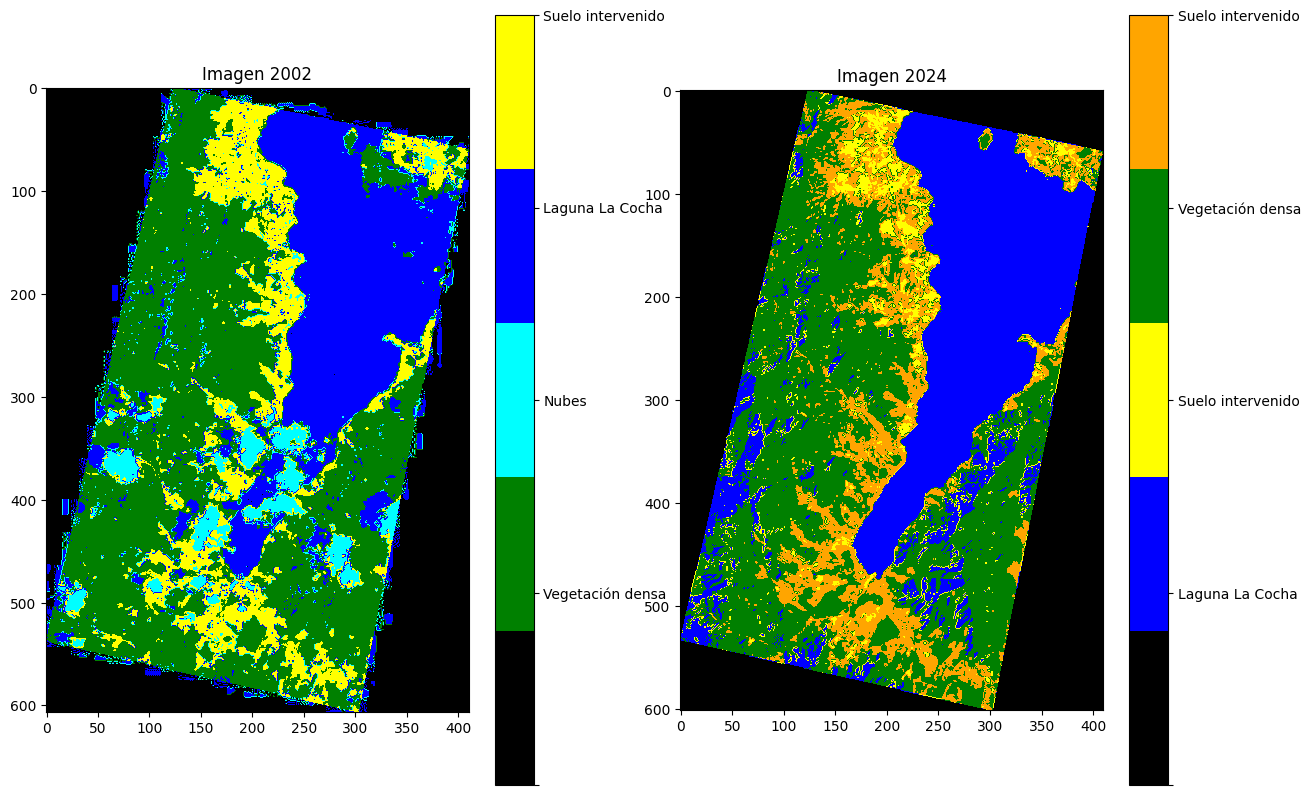

In [ ]:
# Asignar etiqueta de cobertura para diferenciar cada clúster


# Se definen los nombres de los clusters para cada imagen
cluster_names_2002 = {
    1: "Vegetación densa",
    2: "Nubes",
    3: "Laguna La Cocha",
    4: "Suelo intervenido"
}

cluster_names_2024 = {
    1: "Laguna La Cocha",
    2: "Suelo intervenido",
    3: "Vegetación densa",
    4: "Suelo intervenido"
}

# Crea una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

# Crea una paleta de colores distintivos para cada imagen
colors1 = ['black', 'green', 'cyan', 'blue', 'yellow', 'orange', 'cyan', 'magenta']
colors2 = ['black', 'blue', 'yellow', 'green', 'orange', 'orange', 'cyan', 'magenta']

# Crear mapas de colores para cada imagen (ajustar el número de clusters en cada imagen)
cmap1 = ListedColormap(colors1[:k1+1]) #para incluir el negro
cmap2 = ListedColormap(colors2[:k1+1]) #para incluir el negro

# Mostrar la primera imagen segmentada
im1 = axs[0].imshow(segmented_image1, cmap=cmap1)
axs[0].set_title('Imagen 2002')

# Agregar nombres de los clusters a la barra de color
cbar1 = plt.colorbar(im1, ax=axs[0], ticks=range(k1+1))
cbar1.ax.set_yticklabels([cluster_names_2002.get(i, '') for i in range(k1+1)])

# Mostrar la segunda imagen segmentada
im2 = axs[1].imshow(segmented_image2, cmap=cmap2)
axs[1].set_title('Imagen 2024')

# Agregar nombres de los clusters a la barra de color
cbar2 = plt.colorbar(im2, ax=axs[1], ticks=range(k2+1))
cbar2.ax.set_yticklabels([cluster_names_2024.get(i, '') for i in range(k2+1)])

plt.savefig('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/imagenes_segmentadas_labels.png')

# Mostrar la figura con los subplots y las barras de color
plt.show()


## Cálculos de áreas de cada clúster (cobertura)

Con el fin de establecer la variación entre coberturas desde el año 2002 al 2024, se realizan los cálculos de área de cada clúster. Esto se realiza teniendo en cuenta que la resolución en terreno de las imágenes es de 30m

In [ ]:
# Calcular el área de cada cluster en km² para la imagen 2002
cluster_areas_2002 = {}
for cluster_id in range(1, k1 + 1):
    cluster_mask = (segmented_image1 == cluster_id)
    area_pixels = np.sum(cluster_mask)
    resolucion_espacial = 30  # Resolución espacial en metros
    area_km2 = (area_pixels * (resolucion_espacial ** 2)) / (1000 ** 2)
    cluster_areas_2002[cluster_names_2002[cluster_id]] = area_km2

# Imprimir el área de cada cluster en km² para la imagen 2002
print("-" * 30)
print("Imagen 2002")
print("-" * 30)
for cluster_name, area in cluster_areas_2002.items():
    print(f"{cluster_name}: {area:.2f} km²")

# Calcular el área de cada cluster en km² para la imagen 2024
cluster_areas_2024 = {}
for cluster_id in range(1, k2 + 1):
    cluster_mask = (segmented_image2 == cluster_id)
    area_pixels = np.sum(cluster_mask)
    resolucion_espacial = 30  # Resolución espacial en metros
    area_km2 = (area_pixels * (resolucion_espacial ** 2)) / (1000 ** 2)

    # Sumar áreas si el cluster tiene el mismo nombre
    cluster_name = cluster_names_2024[cluster_id]
    if cluster_name in cluster_areas_2024:
        cluster_areas_2024[cluster_name] += area_km2
    else:
        cluster_areas_2024[cluster_name] = area_km2

# Imprimir el área de cada cluster en km² para la imagen 2024
print("\n" + "-" * 30)
print("Imagen 2024")
print("-" * 30)
for cluster_name, area in cluster_areas_2024.items():
    print(f"{cluster_name}: {area:.2f} km²")



------------------------------
Imagen 2002
------------------------------
Vegetación densa: 78.30 km²
Nubes: 7.44 km²
Laguna La Cocha: 44.04 km²
Suelo intervenido: 26.05 km²

------------------------------
Imagen 2024
------------------------------
Laguna La Cocha: 51.29 km²
Suelo intervenido: 27.88 km²
Vegetación densa: 70.42 km²


In [ ]:
# Crea un diccionario con los datos de las áreas
data = {
    'Cobertura': list(cluster_areas_2002.keys()) + list(cluster_areas_2024.keys()),
    'Area_2002_km2': [cluster_areas_2002.get(key, 0) for key in list(cluster_areas_2002.keys()) + list(cluster_areas_2024.keys())],
    'Area_2024_km2': [cluster_areas_2024.get(key, 0) for key in list(cluster_areas_2002.keys()) + list(cluster_areas_2024.keys())]
}

# Crea un DataFrame a partir del diccionario
df_areas = pd.DataFrame(data)

# Guarda el DataFrame en un archivo CSV
df_areas.to_csv('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/areas_coberturas.csv', index=False)

## Variación de áreas

In [ ]:
# Calcular diferencia de área para entre las dos imagenes

# Calcula la diferencia de área entre las dos imágenes
area_diff = {}
for cluster_name in cluster_areas_2002:
  if cluster_name in cluster_areas_2024:
    diff = cluster_areas_2024[cluster_name] - cluster_areas_2002[cluster_name]
    area_diff[cluster_name] = diff
  else:
    area_diff[cluster_name] = -cluster_areas_2002[cluster_name]  # Si no existe en 2024, la diferencia es negativa

for cluster_name in cluster_areas_2024:
  if cluster_name not in cluster_areas_2002:
    area_diff[cluster_name] = cluster_areas_2024[cluster_name]  # Si no existe en 2002, la diferencia es el área de 2024

# Imprime la diferencia de área para cada cluster
print("\n" + "-" * 30)
print("Diferencia de área entre imágenes")
print("-" * 30)
for cluster_name, diff in area_diff.items():
  print(f"{cluster_name}: {diff:.2f} km²")



------------------------------
Diferencia de área entre imágenes
------------------------------
Vegetación densa: -7.88 km²
Nubes: -7.44 km²
Laguna La Cocha: 7.25 km²
Suelo intervenido: 1.83 km²


In [ ]:
# Crea un diccionario con los datos de las diferencias de área
data_diff = {
    'Cobertura': list(area_diff.keys()),
    'Diferencia_Area_km2': list(area_diff.values())
}

# Crea un DataFrame a partir del diccionario
df_diff = pd.DataFrame(data_diff)

# Guarda el DataFrame en un archivo CSV
df_diff.to_csv('/content/drive/MyDrive/TFM/Repositorio/2-cover_land_k-means/Results/diferencia_areas_coberturas.csv', index=False)
